# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [196]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset()

In [3]:
print(attrs.shape)
print(data.shape)
attrs.head()

(13143, 73)
(13143, 45, 45, 3)


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,...,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,...,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,...,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,...,-1.46147,-0.955283,0.119113,-1.12818,-3.16105,0.0826804,-0.439614,-0.359859,-0.760774,-0.410152


In [4]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [5]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [355]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

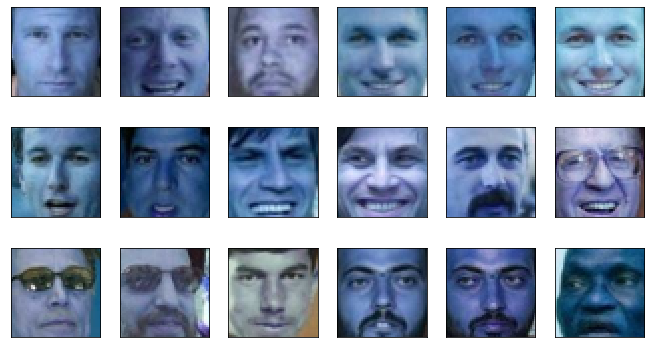

In [354]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [445]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

vanila_encoder = L.Dense(
    units=dimZ,
)
vanila_decoder = L.Dense(
    units=image_h * image_w * 3,
    activation='sigmoid'
)
model = tf.keras.Sequential()
model.add(vanila_encoder)
model.add(vanila_decoder)

In [446]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate
    
    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

In [447]:
# Create MSE loss function
loss = tf.keras.losses.MeanSquaredError()
# Use Adam optimizer
opt = tf.keras.optimizers.Adam()
model.compile(loss=loss, optimizer=opt, metrics=['acc'])
callback = DisplayCallback(model, 10)

Epoch 1/100
200/200 [==============================] - 3s 11ms/step - loss: 0.0246 - acc: 0.0026 - val_loss: 0.0119 - val_acc: 0.0054


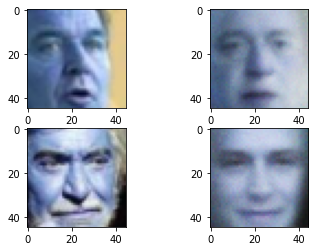

Epoch 2/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0112 - acc: 0.0080 - val_loss: 0.0099 - val_acc: 0.0099
Epoch 3/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0092 - acc: 0.0087 - val_loss: 0.0090 - val_acc: 0.0134
Epoch 4/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0083 - acc: 0.0144 - val_loss: 0.0078 - val_acc: 0.0127
Epoch 5/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0075 - acc: 0.0140 - val_loss: 0.0069 - val_acc: 0.0188
Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0070 - acc: 0.0209 - val_loss: 0.0064 - val_acc: 0.0213
Epoch 7/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0062 - acc: 0.0191 - val_loss: 0.0062 - val_acc: 0.0251
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0059 - acc: 0.0245 - val_loss: 0.0062 - val_acc: 0.0242
Epoch 9/100
200/200 [==============================] - 2s 9ms/s

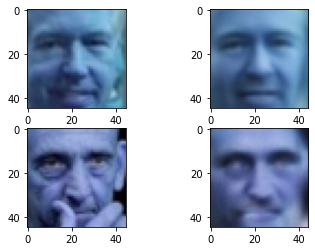

Epoch 12/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0050 - acc: 0.0263 - val_loss: 0.0053 - val_acc: 0.0251
Epoch 13/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0050 - acc: 0.0301 - val_loss: 0.0045 - val_acc: 0.0280
Epoch 14/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0045 - acc: 0.0252 - val_loss: 0.0047 - val_acc: 0.0290
Epoch 15/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0045 - acc: 0.0284 - val_loss: 0.0042 - val_acc: 0.0277
Epoch 16/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0042 - acc: 0.0268 - val_loss: 0.0041 - val_acc: 0.0280
Epoch 17/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0041 - acc: 0.0284 - val_loss: 0.0042 - val_acc: 0.0283
Epoch 18/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0040 - acc: 0.0313 - val_loss: 0.0041 - val_acc: 0.0245
Epoch 19/100
200/200 [==============================] - 

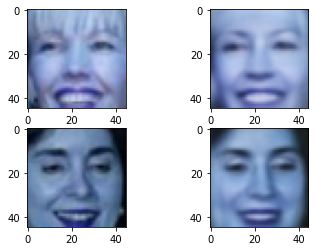

Epoch 22/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0037 - acc: 0.0332 - val_loss: 0.0050 - val_acc: 0.0325
Epoch 23/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0038 - acc: 0.0315 - val_loss: 0.0038 - val_acc: 0.0245
Epoch 24/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0035 - acc: 0.0366 - val_loss: 0.0035 - val_acc: 0.0312
Epoch 25/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0036 - acc: 0.0281 - val_loss: 0.0038 - val_acc: 0.0270
Epoch 26/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0034 - acc: 0.0298 - val_loss: 0.0034 - val_acc: 0.0315
Epoch 27/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0034 - acc: 0.0323 - val_loss: 0.0033 - val_acc: 0.0350
Epoch 28/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0034 - acc: 0.0312 - val_loss: 0.0034 - val_acc: 0.0248
Epoch 29/100
200/200 [==============================] -

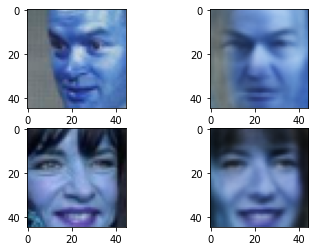

Epoch 32/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0032 - acc: 0.0320 - val_loss: 0.0030 - val_acc: 0.0318
Epoch 33/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0033 - acc: 0.0326 - val_loss: 0.0036 - val_acc: 0.0315
Epoch 34/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0033 - acc: 0.0345 - val_loss: 0.0031 - val_acc: 0.0290
Epoch 35/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0031 - acc: 0.0363 - val_loss: 0.0031 - val_acc: 0.0293
Epoch 36/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0031 - acc: 0.0290 - val_loss: 0.0030 - val_acc: 0.0318
Epoch 37/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0030 - acc: 0.0336 - val_loss: 0.0030 - val_acc: 0.0296
Epoch 38/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0030 - acc: 0.0340 - val_loss: 0.0030 - val_acc: 0.0334
Epoch 39/100
200/200 [==============================] - 2s 9

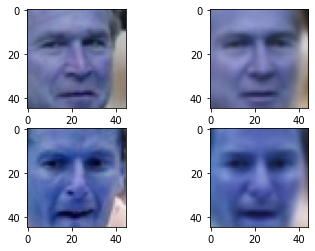

Epoch 42/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0030 - acc: 0.0284 - val_loss: 0.0030 - val_acc: 0.0280
Epoch 43/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0030 - acc: 0.0297 - val_loss: 0.0031 - val_acc: 0.0315
Epoch 44/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0029 - acc: 0.0324 - val_loss: 0.0029 - val_acc: 0.0321
Epoch 45/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0029 - acc: 0.0315 - val_loss: 0.0029 - val_acc: 0.0267
Epoch 46/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0030 - acc: 0.0307 - val_loss: 0.0029 - val_acc: 0.0290
Epoch 47/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0029 - acc: 0.0304 - val_loss: 0.0029 - val_acc: 0.0293
Epoch 48/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0029 - acc: 0.0340 - val_loss: 0.0029 - val_acc: 0.0321
Epoch 49/100
200/200 [==============================] - 2s 9

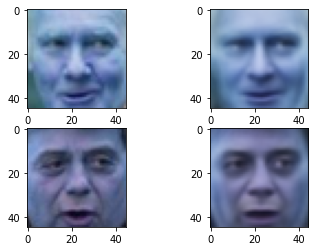

Epoch 52/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0029 - acc: 0.0341 - val_loss: 0.0029 - val_acc: 0.0290
Epoch 53/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0305 - val_loss: 0.0029 - val_acc: 0.0325
Epoch 54/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0030 - acc: 0.0296 - val_loss: 0.0029 - val_acc: 0.0334
Epoch 55/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0325 - val_loss: 0.0028 - val_acc: 0.0305
Epoch 56/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0301 - val_loss: 0.0029 - val_acc: 0.0258
Epoch 57/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0031 - acc: 0.0327 - val_loss: 0.0028 - val_acc: 0.0331
Epoch 58/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0337 - val_loss: 0.0029 - val_acc: 0.0296
Epoch 59/100
200/200 [==============================] - 2s 9

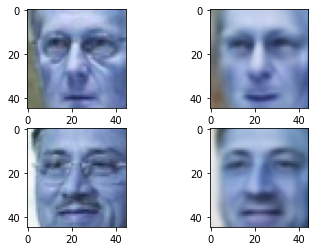

Epoch 62/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0029 - acc: 0.0288 - val_loss: 0.0028 - val_acc: 0.0290
Epoch 63/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0029 - acc: 0.0306 - val_loss: 0.0028 - val_acc: 0.0280
Epoch 64/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0339 - val_loss: 0.0029 - val_acc: 0.0312
Epoch 65/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0335 - val_loss: 0.0030 - val_acc: 0.0293
Epoch 66/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0299 - val_loss: 0.0029 - val_acc: 0.0356
Epoch 67/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0334 - val_loss: 0.0028 - val_acc: 0.0299
Epoch 68/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0027 - acc: 0.0307 - val_loss: 0.0028 - val_acc: 0.0309
Epoch 69/100
200/200 [==============================] - 2s 

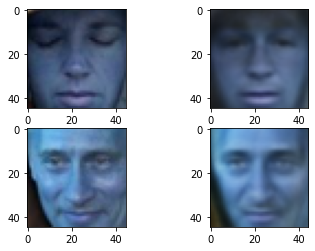

Epoch 72/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0303 - val_loss: 0.0028 - val_acc: 0.0305
Epoch 73/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0289 - val_loss: 0.0028 - val_acc: 0.0334
Epoch 74/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0308 - val_loss: 0.0028 - val_acc: 0.0337
Epoch 75/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0309 - val_loss: 0.0028 - val_acc: 0.0318
Epoch 76/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0299 - val_loss: 0.0029 - val_acc: 0.0331
Epoch 77/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0341 - val_loss: 0.0028 - val_acc: 0.0347
Epoch 78/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0297 - val_loss: 0.0028 - val_acc: 0.0315
Epoch 79/100
200/200 [==============================] - 2s 1

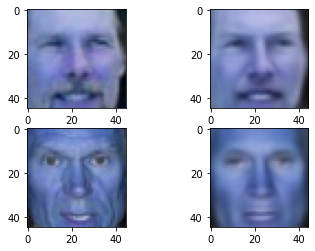

Epoch 82/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0027 - acc: 0.0341 - val_loss: 0.0030 - val_acc: 0.0334
Epoch 83/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0332 - val_loss: 0.0028 - val_acc: 0.0305
Epoch 84/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0342 - val_loss: 0.0028 - val_acc: 0.0290
Epoch 85/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0299 - val_loss: 0.0028 - val_acc: 0.0347
Epoch 86/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0305 - val_loss: 0.0028 - val_acc: 0.0315
Epoch 87/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0328 - val_loss: 0.0027 - val_acc: 0.0321
Epoch 88/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0027 - acc: 0.0315 - val_loss: 0.0028 - val_acc: 0.0312
Epoch 89/100
200/200 [==============================] - 2s

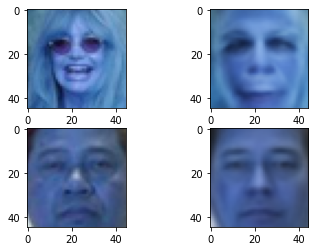

Epoch 92/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0309 - val_loss: 0.0028 - val_acc: 0.0296
Epoch 93/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0027 - acc: 0.0312 - val_loss: 0.0028 - val_acc: 0.0309
Epoch 94/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0322 - val_loss: 0.0028 - val_acc: 0.0363
Epoch 95/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0309 - val_loss: 0.0028 - val_acc: 0.0293
Epoch 96/100
200/200 [==============================] - 2s 10ms/step - loss: 0.0028 - acc: 0.0336 - val_loss: 0.0030 - val_acc: 0.0299
Epoch 97/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0028 - acc: 0.0320 - val_loss: 0.0028 - val_acc: 0.0305
Epoch 98/100
200/200 [==============================] - 2s 9ms/step - loss: 0.0027 - acc: 0.0274 - val_loss: 0.0027 - val_acc: 0.0274
Epoch 99/100
200/200 [==============================] - 2s

In [448]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    callbacks=[callback],
    batch_size=50,
    epochs=100
)

In [449]:
model.save_weights('./vanila.hdf5')

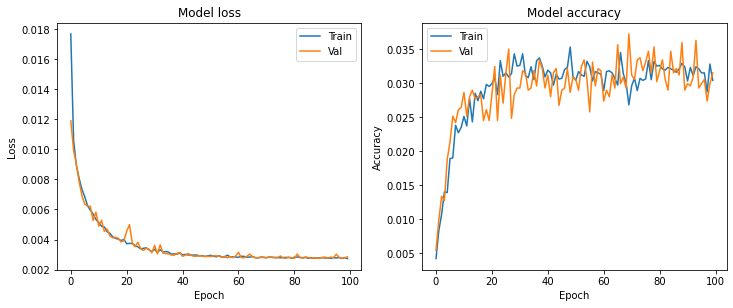

In [450]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(222)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

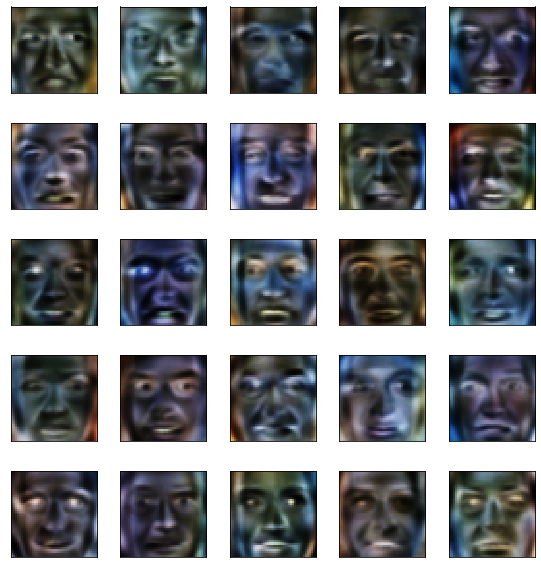

In [479]:
z = np.random.randn(25, dimZ) * 2
output = vanila_decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [279]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
class Sampling(L.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

enc_inp = L.Input(
    shape=(image_h * image_w * 3,),
    name='encoder_input'
)
encoding = L.Dense(
    units=dimZ,
    name='encoding'
)(enc_inp)
mean = L.Dense(
    units=dimZ,
    name='mean'
)(encoding)
log_var = L.Dense(
    units=dimZ,
    name='log_var'
)(encoding)
sample = Sampling(name='sample')([mean, log_var])
encoder = tf.keras.Model(enc_inp, [mean, log_var, sample])

dec_inp = L.Input(
    shape=(dimZ,),
    name='decoder_input'
)
decoding = L.Dense(
    units=image_h * image_w * 3,
    activation='sigmoid',
    name='decoding'
)(dec_inp)
decoder = tf.keras.Model(dec_inp, decoding)

encoder.summary()
decoder.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 6075)]       0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 100)          607600      encoder_input[0][0]              
__________________________________________________________________________________________________
mean (Dense)                    (None, 100)          10100       encoding[0][0]                   
__________________________________________________________________________________________________
log_var (Dense)                 (None, 100)          10100       encoding[0][0]                   
___________________________________________________________________________________________

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [280]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # We use log sigma because it's more proportional to the mean
    # and sigma would be too small and it will be harder to optimize
    
    @tf.function
    def KL_divergence(self, mu, logsigma):
        return tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + logsigma - tf.square(mu) - tf.exp(logsigma)),
                axis=1
            )
        )

    @tf.function
    def log_likelihood(self, x, z):
        reconstruction = self.decoder(z)
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.square(x-reconstruction), axis=-1
            )
        )
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction_loss = self.log_likelihood(data, z)
            kl_loss = self.KL_divergence(z_mean, z_log_var)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = self.log_likelihood(inputs, z)
        kl_loss = self.KL_divergence(z_mean, z_log_var)
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return reconstruction

In [281]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
callback = DisplayCallback(vae, 2)
early_stop = EarlyStopping(
    monitor='val_total_loss',
    patience=5, 
    restore_best_weights=True
)

And train the model:

Epoch 1/50
1000/1000 [==============================] - 5s 5ms/step - loss: 340.8592 - reconstruction_loss: 122.7419 - kl_loss: 55.2314 - val_total_loss: 120.3170 - val_reconstruction_loss: 90.6161 - val_kl_loss: 29.7008


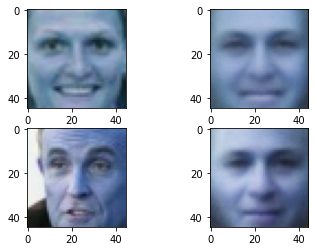

Epoch 2/50
1000/1000 [==============================] - 5s 5ms/step - loss: 105.9255 - reconstruction_loss: 75.2756 - kl_loss: 26.3719 - val_total_loss: 91.9153 - val_reconstruction_loss: 66.3831 - val_kl_loss: 25.5323
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/step - loss: 90.4395 - reconstruction_loss: 63.1262 - kl_loss: 25.2282 - val_total_loss: 82.7279 - val_reconstruction_loss: 59.3164 - val_kl_loss: 23.4114


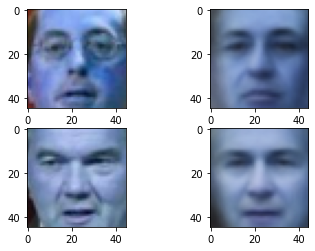

Epoch 4/50
1000/1000 [==============================] - 5s 5ms/step - loss: 81.9730 - reconstruction_loss: 56.3177 - kl_loss: 23.7678 - val_total_loss: 77.1093 - val_reconstruction_loss: 56.2393 - val_kl_loss: 20.8700
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 74.1868 - reconstruction_loss: 51.3837 - kl_loss: 22.2764 - val_total_loss: 82.6797 - val_reconstruction_loss: 54.7542 - val_kl_loss: 27.9255


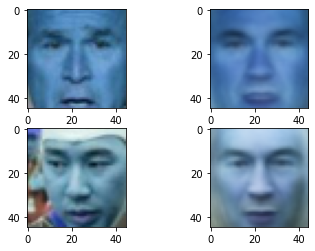

Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 71.1031 - reconstruction_loss: 48.9225 - kl_loss: 21.5455 - val_total_loss: 66.2698 - val_reconstruction_loss: 46.3188 - val_kl_loss: 19.9510
Epoch 7/50
1000/1000 [==============================] - 4s 4ms/step - loss: 69.0092 - reconstruction_loss: 47.6871 - kl_loss: 20.7696 - val_total_loss: 66.5895 - val_reconstruction_loss: 43.2681 - val_kl_loss: 23.3214


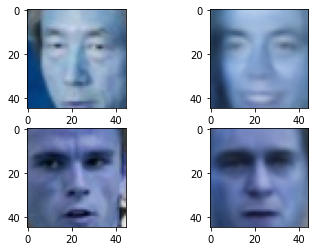

Epoch 8/50
1000/1000 [==============================] - 5s 5ms/step - loss: 68.3689 - reconstruction_loss: 47.3909 - kl_loss: 20.3327 - val_total_loss: 66.0252 - val_reconstruction_loss: 46.1950 - val_kl_loss: 19.8303
Epoch 9/50
1000/1000 [==============================] - 5s 5ms/step - loss: 66.3421 - reconstruction_loss: 46.3596 - kl_loss: 19.6452 - val_total_loss: 65.5355 - val_reconstruction_loss: 47.8746 - val_kl_loss: 17.6609


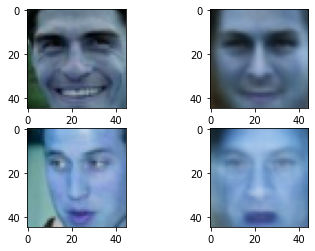

Epoch 10/50
1000/1000 [==============================] - 4s 4ms/step - loss: 66.1012 - reconstruction_loss: 46.4884 - kl_loss: 19.3464 - val_total_loss: 63.9416 - val_reconstruction_loss: 45.5140 - val_kl_loss: 18.4276
Epoch 11/50
1000/1000 [==============================] - 4s 4ms/step - loss: 64.6581 - reconstruction_loss: 46.1216 - kl_loss: 18.9409 - val_total_loss: 68.9847 - val_reconstruction_loss: 50.6801 - val_kl_loss: 18.3045


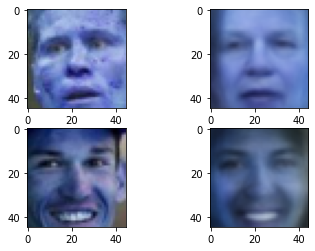

Epoch 12/50
1000/1000 [==============================] - 4s 4ms/step - loss: 64.9316 - reconstruction_loss: 45.7691 - kl_loss: 18.7345 - val_total_loss: 66.0602 - val_reconstruction_loss: 46.8900 - val_kl_loss: 19.1703
Epoch 13/50
1000/1000 [==============================] - 5s 5ms/step - loss: 64.8661 - reconstruction_loss: 45.9679 - kl_loss: 18.6047 - val_total_loss: 65.4555 - val_reconstruction_loss: 46.5618 - val_kl_loss: 18.8937


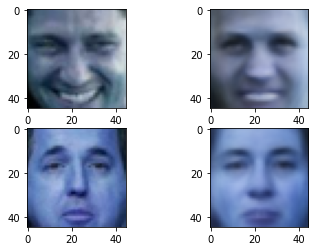

Epoch 14/50
1000/1000 [==============================] - 5s 5ms/step - loss: 63.6154 - reconstruction_loss: 45.2630 - kl_loss: 18.3887 - val_total_loss: 63.5684 - val_reconstruction_loss: 44.1507 - val_kl_loss: 19.4177
Epoch 15/50
1000/1000 [==============================] - 5s 5ms/step - loss: 63.1722 - reconstruction_loss: 44.8330 - kl_loss: 18.3560 - val_total_loss: 62.5658 - val_reconstruction_loss: 44.3586 - val_kl_loss: 18.2072


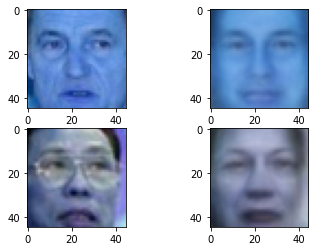

Epoch 16/50
1000/1000 [==============================] - 5s 5ms/step - loss: 63.4230 - reconstruction_loss: 44.8238 - kl_loss: 18.3244 - val_total_loss: 62.4722 - val_reconstruction_loss: 43.6409 - val_kl_loss: 18.8313
Epoch 17/50
1000/1000 [==============================] - 5s 5ms/step - loss: 62.8568 - reconstruction_loss: 44.5295 - kl_loss: 18.2037 - val_total_loss: 61.7927 - val_reconstruction_loss: 42.6395 - val_kl_loss: 19.1532


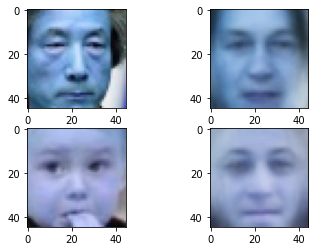

Epoch 18/50
1000/1000 [==============================] - 4s 4ms/step - loss: 62.4003 - reconstruction_loss: 44.3950 - kl_loss: 18.1710 - val_total_loss: 62.0497 - val_reconstruction_loss: 44.0891 - val_kl_loss: 17.9605
Epoch 19/50
1000/1000 [==============================] - 4s 4ms/step - loss: 62.3022 - reconstruction_loss: 44.5565 - kl_loss: 18.1447 - val_total_loss: 61.1520 - val_reconstruction_loss: 42.7462 - val_kl_loss: 18.4058


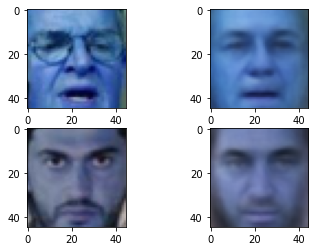

Epoch 20/50
1000/1000 [==============================] - 4s 4ms/step - loss: 62.1494 - reconstruction_loss: 44.1423 - kl_loss: 17.9810 - val_total_loss: 62.5431 - val_reconstruction_loss: 44.2972 - val_kl_loss: 18.2459
Epoch 21/50
1000/1000 [==============================] - 5s 5ms/step - loss: 62.3309 - reconstruction_loss: 44.1860 - kl_loss: 18.0632 - val_total_loss: 61.7454 - val_reconstruction_loss: 44.3754 - val_kl_loss: 17.3700


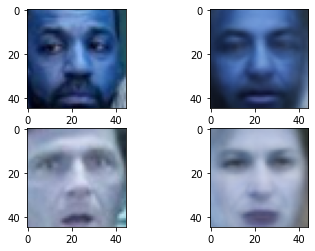

Epoch 22/50
1000/1000 [==============================] - 5s 5ms/step - loss: 61.7076 - reconstruction_loss: 43.9638 - kl_loss: 17.9648 - val_total_loss: 63.1166 - val_reconstruction_loss: 44.1619 - val_kl_loss: 18.9547
Epoch 23/50
1000/1000 [==============================] - 4s 4ms/step - loss: 62.3769 - reconstruction_loss: 44.0769 - kl_loss: 17.9040 - val_total_loss: 62.1980 - val_reconstruction_loss: 43.6793 - val_kl_loss: 18.5187


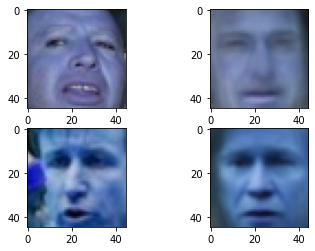

Epoch 24/50
1000/1000 [==============================] - 5s 5ms/step - loss: 61.9002 - reconstruction_loss: 43.9343 - kl_loss: 17.8836 - val_total_loss: 61.2713 - val_reconstruction_loss: 43.4024 - val_kl_loss: 17.8688
Epoch 25/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.5278 - reconstruction_loss: 43.7699 - kl_loss: 17.8956 - val_total_loss: 60.9875 - val_reconstruction_loss: 42.6514 - val_kl_loss: 18.3362


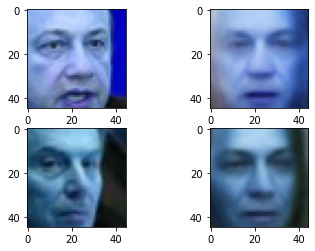

Epoch 26/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.6907 - reconstruction_loss: 43.6782 - kl_loss: 17.8471 - val_total_loss: 60.7955 - val_reconstruction_loss: 43.4763 - val_kl_loss: 17.3192
Epoch 27/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.7160 - reconstruction_loss: 43.8193 - kl_loss: 17.8810 - val_total_loss: 59.9693 - val_reconstruction_loss: 42.6244 - val_kl_loss: 17.3448


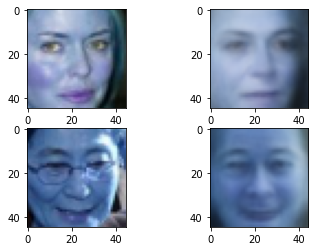

Epoch 28/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.4643 - reconstruction_loss: 43.7334 - kl_loss: 17.8233 - val_total_loss: 60.1975 - val_reconstruction_loss: 42.6359 - val_kl_loss: 17.5617
Epoch 29/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.3355 - reconstruction_loss: 43.6885 - kl_loss: 17.8271 - val_total_loss: 61.3170 - val_reconstruction_loss: 43.8389 - val_kl_loss: 17.4780


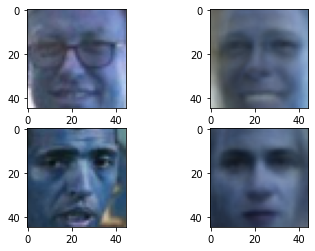

Epoch 30/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.6803 - reconstruction_loss: 43.7838 - kl_loss: 17.7558 - val_total_loss: 60.8838 - val_reconstruction_loss: 44.2387 - val_kl_loss: 16.6451
Epoch 31/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.0022 - reconstruction_loss: 43.6216 - kl_loss: 17.7418 - val_total_loss: 61.5766 - val_reconstruction_loss: 44.2744 - val_kl_loss: 17.3022


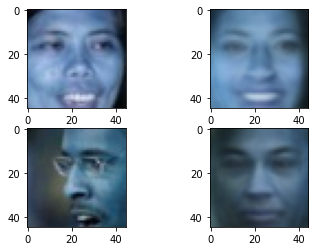

Epoch 32/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.4821 - reconstruction_loss: 43.6232 - kl_loss: 17.7254 - val_total_loss: 59.9886 - val_reconstruction_loss: 42.4864 - val_kl_loss: 17.5022
Epoch 33/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.1294 - reconstruction_loss: 43.5810 - kl_loss: 17.6925 - val_total_loss: 60.4215 - val_reconstruction_loss: 43.0745 - val_kl_loss: 17.3470


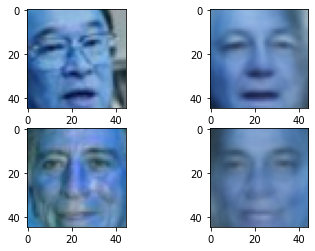

Epoch 34/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.7484 - reconstruction_loss: 43.5926 - kl_loss: 17.6919 - val_total_loss: 61.8553 - val_reconstruction_loss: 45.0947 - val_kl_loss: 16.7605
Epoch 35/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.7973 - reconstruction_loss: 43.6912 - kl_loss: 17.7085 - val_total_loss: 60.0342 - val_reconstruction_loss: 42.5701 - val_kl_loss: 17.4641


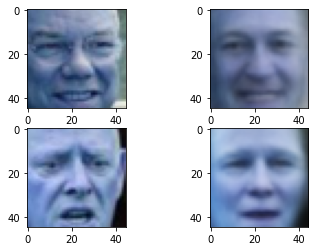

Epoch 36/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.2069 - reconstruction_loss: 43.4993 - kl_loss: 17.6056 - val_total_loss: 59.9847 - val_reconstruction_loss: 42.6055 - val_kl_loss: 17.3793
Epoch 37/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.4277 - reconstruction_loss: 43.5249 - kl_loss: 17.6940 - val_total_loss: 59.8959 - val_reconstruction_loss: 42.9148 - val_kl_loss: 16.9811


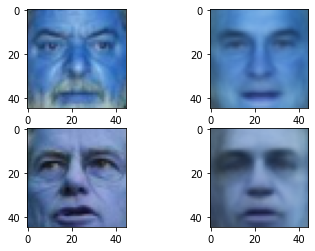

Epoch 38/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.0602 - reconstruction_loss: 43.5781 - kl_loss: 17.6191 - val_total_loss: 63.1713 - val_reconstruction_loss: 46.2897 - val_kl_loss: 16.8815
Epoch 39/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.1685 - reconstruction_loss: 43.4098 - kl_loss: 17.5643 - val_total_loss: 59.5934 - val_reconstruction_loss: 43.1933 - val_kl_loss: 16.4002


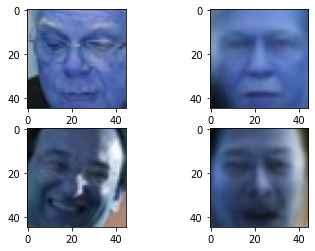

Epoch 40/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.0101 - reconstruction_loss: 43.4908 - kl_loss: 17.5880 - val_total_loss: 62.3538 - val_reconstruction_loss: 43.9596 - val_kl_loss: 18.3941
Epoch 41/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.5724 - reconstruction_loss: 43.4563 - kl_loss: 17.5613 - val_total_loss: 60.6122 - val_reconstruction_loss: 42.9041 - val_kl_loss: 17.7081


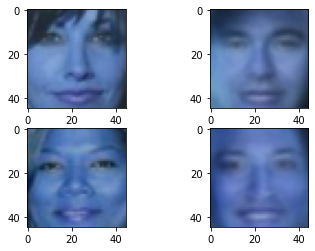

Epoch 42/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.8522 - reconstruction_loss: 43.4853 - kl_loss: 17.6135 - val_total_loss: 59.7880 - val_reconstruction_loss: 41.7174 - val_kl_loss: 18.0706
Epoch 43/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.7078 - reconstruction_loss: 43.3967 - kl_loss: 17.5676 - val_total_loss: 60.1193 - val_reconstruction_loss: 42.6446 - val_kl_loss: 17.4747


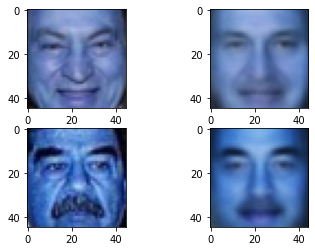

Epoch 44/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.6336 - reconstruction_loss: 43.4493 - kl_loss: 17.5431 - val_total_loss: 60.6480 - val_reconstruction_loss: 43.0254 - val_kl_loss: 17.6226
Epoch 45/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.8440 - reconstruction_loss: 43.3717 - kl_loss: 17.5511 - val_total_loss: 59.8761 - val_reconstruction_loss: 42.6282 - val_kl_loss: 17.2479


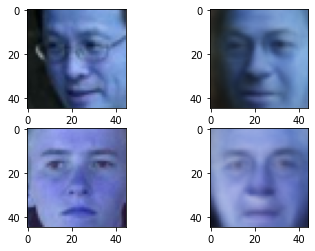

Epoch 46/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.5866 - reconstruction_loss: 43.2973 - kl_loss: 17.5329 - val_total_loss: 60.6446 - val_reconstruction_loss: 43.3325 - val_kl_loss: 17.3121
Epoch 47/50
1000/1000 [==============================] - 4s 4ms/step - loss: 61.0105 - reconstruction_loss: 43.3475 - kl_loss: 17.5406 - val_total_loss: 59.6920 - val_reconstruction_loss: 42.6831 - val_kl_loss: 17.0089


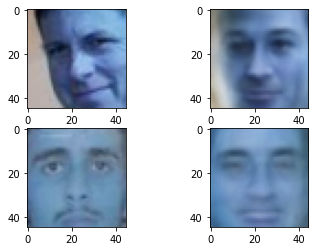

Epoch 48/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.8180 - reconstruction_loss: 43.5011 - kl_loss: 17.5032 - val_total_loss: 60.6457 - val_reconstruction_loss: 43.5608 - val_kl_loss: 17.0849
Epoch 49/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.9172 - reconstruction_loss: 43.3257 - kl_loss: 17.4949 - val_total_loss: 60.3599 - val_reconstruction_loss: 43.2428 - val_kl_loss: 17.1171


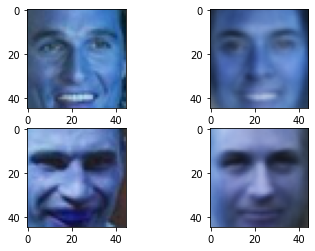

Epoch 50/50
1000/1000 [==============================] - 4s 4ms/step - loss: 60.7763 - reconstruction_loss: 43.2128 - kl_loss: 17.4875 - val_total_loss: 60.5510 - val_reconstruction_loss: 43.2866 - val_kl_loss: 17.2644


In [282]:
history = vae.fit(
    X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=10,
    callbacks=[callback]
)

In [287]:
vae.save_weights('./vae_weights.hdf5')

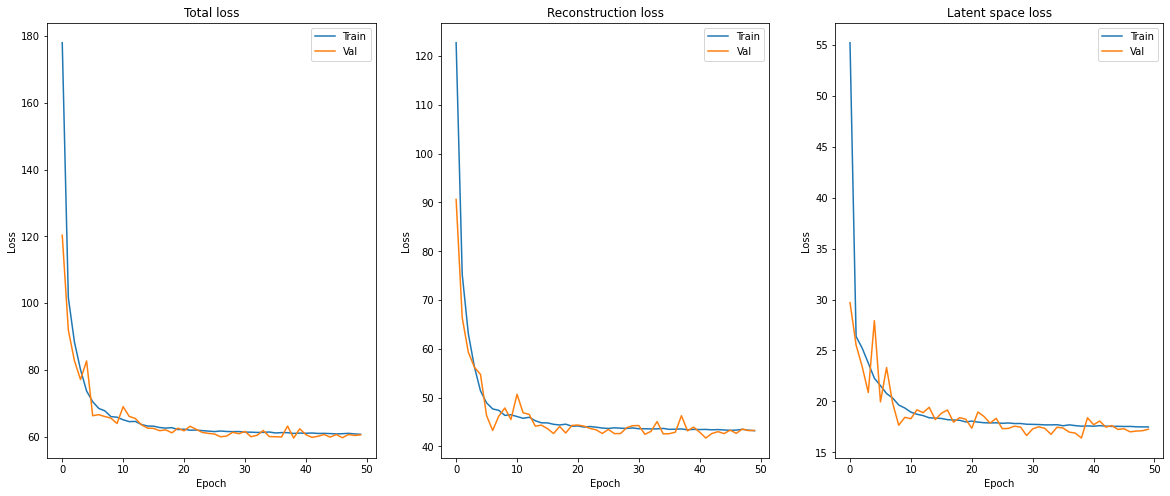

In [303]:
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# train_acc = history.history['acc']
# val_acc = history.history['val_acc']

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_total_loss'])
plt.title('Total loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(132)
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['val_reconstruction_loss'])
plt.title('Reconstruction loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(133)
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('Latent space loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

And finally sample from VAE.

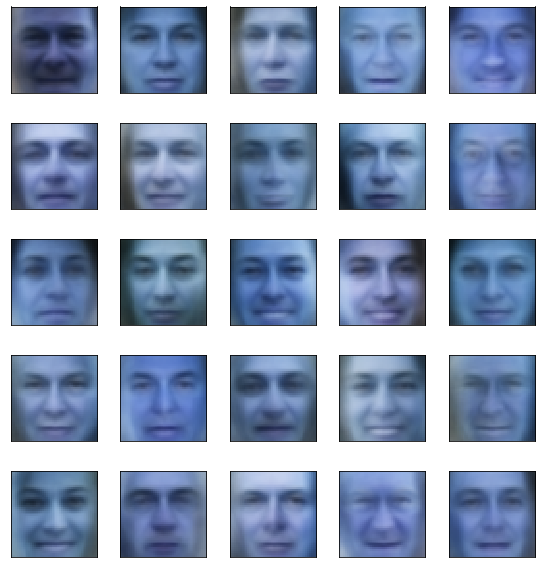

In [481]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))
z = np.random.randn(25, dimZ) * 0.5
output = decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

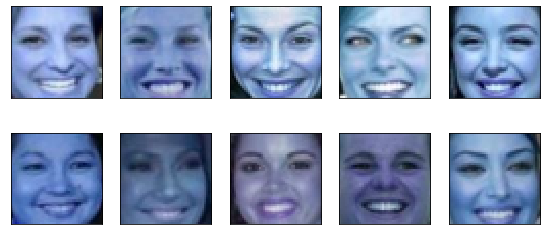

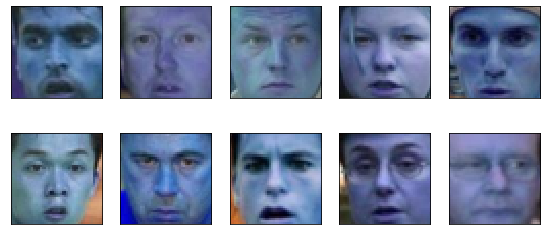

In [441]:
sorted_smiling = attrs.Smiling.argsort().values
idx_smiling = sorted_smiling[-10:][::-1]
idx_non_smiling = sorted_smiling[:10]
X_smiling = data[idx_smiling] / 255.0
X_non_smiling = data[idx_non_smiling] / 255.0 
plot_gallery(X_smiling, image_h, image_w, n_row=2, n_col=5)
plot_gallery(X_non_smiling, image_h, image_w, n_row=2, n_col=5)

In [442]:
smile_mean, smile_log_var, smile = encoder(X_smiling.reshape(10, -1))
smile_mean = smile_mean.numpy().mean(axis=0)
smile_log_var = smile_log_var.numpy().mean(axis=0)
smile = smile.numpy().mean(axis=0)
non_smile_mean, non_smile_log_var, non_smile = encoder(X_non_smiling.reshape(10, -1))
non_smile_mean = non_smile_mean.numpy().mean(axis=0)
non_smile_log_var = non_smile_log_var.numpy().mean(axis=0)
non_smile = non_smile.numpy().mean(axis=0)
diff_mean = smile_mean - non_smile_mean
diff_log_var = smile_log_var - non_smile_log_var
diff = smile - non_smile

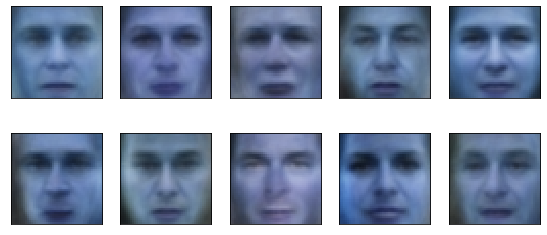

In [475]:
z = np.random.randn(10, dimZ)
output = decoder(non_smile_mean + np.exp(0.5 * non_smile_log_var) * z).numpy()
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

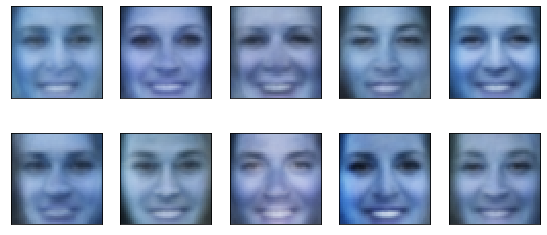

In [477]:
smiling_output = decoder(smile_mean + np.exp(0.5 * smile_log_var) * z).numpy()
plot_gallery(smiling_output, image_h, image_w, n_row=2, n_col=5)

Not only does it make them smile, but it also feminizes them)

Now let's try it with vanila autoencoder

In [454]:
smile = vanila_encoder(X_smiling.reshape(10, -1))
smile = smile.numpy().mean(axis=0)
non_smile = vanila_encoder(X_non_smiling.reshape(10, -1))
non_smile = non_smile.numpy().mean(axis=0)
diff = smile - non_smile

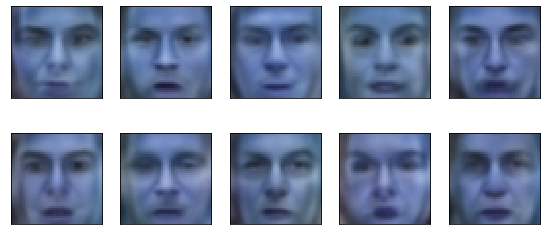

In [470]:
z = np.random.randn(20, dimZ) * 0.5
output = vanila_decoder(non_smile[np.newaxis] + z).numpy()
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

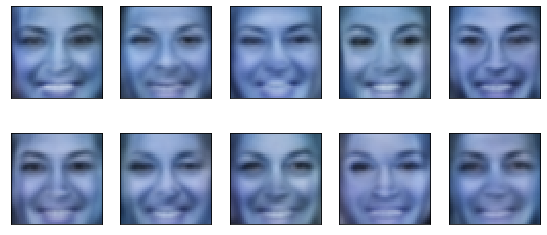

In [472]:
# since here we don't have separate mean and variance 
# the follwing line is equal to 
# output = vanila_decoder(smile[np.newaxis] + z).numpy() 
output = vanila_decoder(non_smile[np.newaxis] + z + diff).numpy()
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

Vanila autoencoders are not suitable for this task